In [1]:
# Standard Libraries
import pandas as pd
import numpy as np

# Matplotlib 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

# Other Libraries 
import datetime
import time
from PIL import Image

# Google Trends Library
from pytrends.request import TrendReq

In [2]:
def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def datetime_to_fraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime.datetime(year=year, month=1, day=1)
    startOfNextYear = datetime.datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [3]:
pytrends = TrendReq(hl='en-US', tz=360) 

In [4]:
social_media = {'MySpace':"#01329b", "bebo":'#c83738', 'friendster':'#228651',
                "Facebook":"#3a589d", "Twitter":"#57aae6", "Snapchat":"#fafe04", 
                "Instagram":"#8a3ab9", "Reddit":"#ff4500","Tiktok": "#00f2ea", 
                "LinkedIn":"#0e76a8", "Tumblr":"#34526f", "Pinterest":"#e60023"}

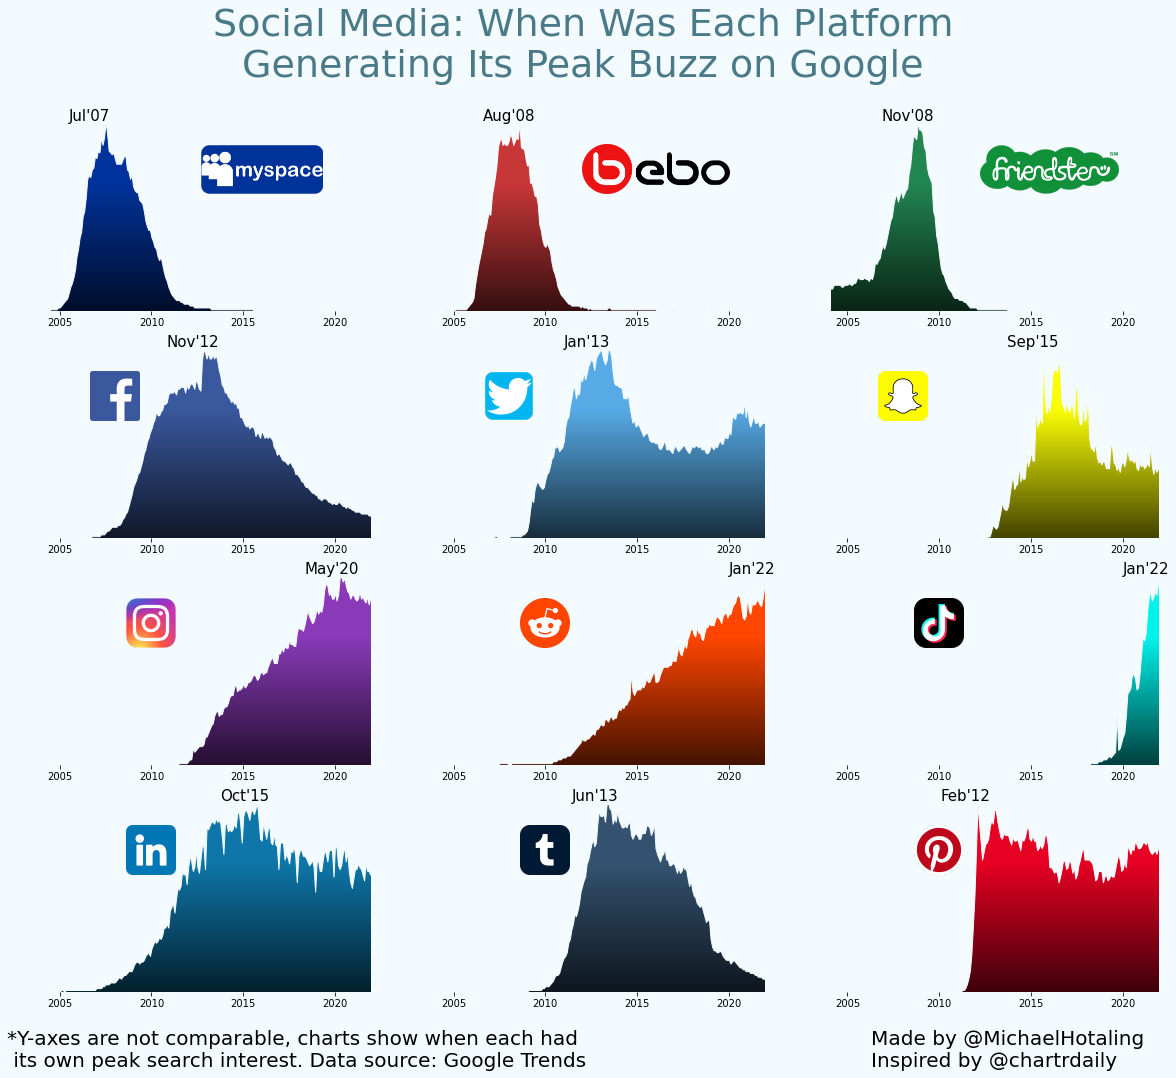

In [18]:

fig, axs = plt.subplots(4, 3, figsize = (20,16))
fig.patch.set_facecolor('#f3fbfe')


for ind, search in enumerate(social_media):
    ind_x = ind//3  # 0, 0, 0, 1, 1, 1...
    ind_y = ind % 3 # 0, 1, 2, 0, 1, 2...
    
    pytrends.build_payload([search], cat=0, timeframe='all') 
    data = pytrends.interest_over_time() 
    
    data['time'] = data.index
    data['time'] = data['time'].apply(lambda x: datetime_to_fraction(x))
    
    c = mcolors.ColorConverter().to_rgb
    custom_cmap = make_colormap(
        [c('#000000'), c(social_media[search]), 0.75,
         c(social_media[search]) ]) 
    
    truncated_cmap = truncate_colormap(custom_cmap, 0.2, 1)
    
    z = [[z] * len(data) for z in range(data[search].max())]

    axs[ind_x,ind_y].contourf(np.linspace(data['time'].min(),
                                          data['time'].max(), 
                                          len(data)),
                              range(100), 
                              z, 600, 
                              cmap = truncated_cmap)
    
    
    axs[ind_x,ind_y].fill_between(np.linspace(data['time'].min(),
                                              data['time'].max(), 
                                              len(data)), 
                                  data[search], 
                                  y2=data[search].max(), 
                                  color='#f3fbfe')
    
    axs[ind_x,ind_y].set_xticks(np.arange(2005, datetime.datetime.now().year, 5))
    axs[ind_x,ind_y].set_ylim(0,100)
    axs[ind_x,ind_y].set_xlim(data['time'].min()+0.1, data['time'].max()-0.1)
    
    img = Image.open(f"icons/{search}.png")
    x,y = img.size
    reshape_x = int(100/y * x) 
    
    img = img.resize((reshape_x,100))

    a = np.asarray(img)
    imagebox = OffsetImage(a, zoom=0.5)
    
    if ind_x == 0:
        ab = AnnotationBbox(imagebox, (2016, 75), frameon=False)
    elif ind_x >= 2:
        ab = AnnotationBbox(imagebox, (2010, 75), frameon=False)
    else:
        ab = AnnotationBbox(imagebox, (2008, 75), frameon=False)
    axs[ind_x,ind_y].add_artist(ab)
    
    text = data[search].idxmax().strftime("%b'%y")

    text_pos_x = data.loc[data[search].idxmax()]['time']

    #if ind_x == 2:
    #    text_pos_x -= 3
        
    axs[ind_x,ind_y].text(text_pos_x-2, 101, text, fontsize=15)
    
    axs[ind_x,ind_y].spines["top"].set_visible(False)
    axs[ind_x,ind_y].spines["right"].set_visible(False)
    axs[ind_x,ind_y].spines["bottom"].set_visible(False) 
    axs[ind_x,ind_y].spines["left"].set_visible(False) 
    #axs[ind_x,ind_y].set_title(f"{search}", color = "#4a7a88", fontsize = 20)
    axs[ind_x,ind_y].set_yticks([])

fig.suptitle("Social Media: When Was Each Platform\nGenerating Its Peak Buzz on Google\n", fontsize=38, color = "#4a7a88")

fig.text(0.7, 0.06, "Made by @MichaelHotaling\nInspired by @chartrdaily", fontsize= 20)

fig.text(0.1, 0.06, "*Y-axes are not comparable, charts show when each had\n its own peak search interest. Data source: Google Trends", fontsize= 20)

plt.show()